This notebook demonstrates Kausal framework on ENSO dynamics.

References: 

- https://www.aoml.noaa.gov/phod/docs/2004_Wang_Picaut.pdf
- https://journals.ametsoc.org/view/journals/atsc/54/7/1520-0469_1997_054_0811_aeorpf_2.0.co_2.xml

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import numpy as np
import torch
import torchdiffeq

import matplotlib.pyplot as plt
from matplotlib import cm, colors as mcolors
from matplotlib.collections import LineCollection
from tqdm import tqdm

from kausal.generator import enso
from kausal.koopman import Kausal
from kausal import stats
from kausal.observables import MLPFeatures


# 1. Generate dynamics 


$$
\frac{\partial T}{\partial t} = -r T - \mu \alpha b_0 h
$$

$$
\frac{\partial h}{\partial t} = \gamma T + (\gamma \mu b_0 - c) h
$$


### 1a. Specify parameters, ICs, timestepping

In [3]:
# Time span
t0, t1 = 0.0, 100.0
dt = 0.01
steps = int((t1 - t0) / dt)
n_train = int(0.8 * steps)

# Parameters
r, alpha, b0, c, gamma = 0.25, 0.125, 2.5, 1.0, 0.75
mu = 2/3 # Coupling term
eps = 0.0 # No nonlinearity

# Initial condition
initial_state = torch.tensor([1.0, 1.0])


### 1b. Integrate forward

In [4]:
# Integration
solver = torchdiffeq.odeint

def solve_dynamics(t0, t1, dt, initial_state, params):
    """Solve dynamics"""
    t = torch.linspace(t0, t1, int((t1 - t0) / dt))
    dynamics = lambda t, state: enso(t, state, params)
    
    solution = solver(
        dynamics,
        initial_state,
        t,
        method = 'dopri5',
        options = {'max_num_steps': 100000}
    )
    return t, solution

params = (r, alpha, b0, c, gamma, mu, eps)

# Solve the system
t, solution = solve_dynamics(t0, t1, dt, initial_state, params)

# Extract results
omega = solution.T


### 1c. Dynamics analysis

We can analyze the bifurcation phase diagram by varying $\mu$

/local/ipykernel_1490667/3716946673.py:35: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  eigenvalues = torch.tensor(eigenvalues)


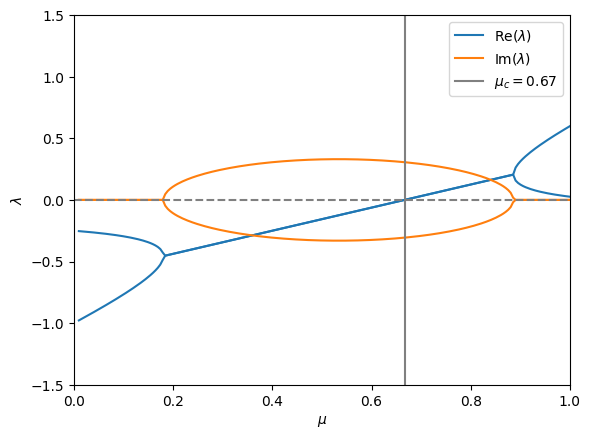

In [5]:
def compute_jacobian(T, h, args):
    """
    Compute the Jacobian matrix for the ENSO system.
    
    Parameters:
        T, h: State variables.
        args: Model parameters.
    
    Returns:
        Jacobian matrix (2x2 numpy array).
    """
    r, alpha, b0, c, gamma, mu, eps = args

    # Partial derivatives
    dT_dT = -r - 3 * eps * T ** 2
    dT_dh = -mu * alpha * b0
    dh_dT = gamma
    dh_dh = gamma * mu * b0 - c

    # Jacobian matrix
    return torch.tensor([[dT_dT, dT_dh], [dh_dT, dh_dh]])


# Define parameters
r, alpha, b0, c, gamma = 0.25, 0.125, 2.5, 1.0, 0.75
eps = 0.0
muvec = np.linspace(0.01, 1.0, 200)  # Range of mu values

# Compute eigenvalues for each value of mu
eigenvalues = []
for mu in muvec:
    args = (r, alpha, b0, c, gamma, mu, eps)
    jacobian = compute_jacobian(0, 0, args)  # Jacobian evaluated at T=0, h=0 (fixed point)
    eigenvalues.append(torch.linalg.eigvals(jacobian).numpy())
eigenvalues = torch.tensor(eigenvalues)

# Plotting eigenvalues
f, ax = plt.subplots()
ax.set_xlabel(r'$\mu$')
ax.set_ylabel(r'$\lambda$')
ax.set_xlim(0, 1)
ax.set_ylim(-1.5, 1.5)

# Real and imaginary parts
ax.plot(muvec, np.real(eigenvalues[:, 0]), color='C0', label=r'Re($\lambda$)')
ax.plot(muvec, np.real(eigenvalues[:, 1]), color='C0')
ax.plot(muvec, np.imag(eigenvalues[:, 0]), color='C1', label=r'Im($\lambda$)')
ax.plot(muvec, np.imag(eigenvalues[:, 1]), color='C1')

# Mark critical values of mu
ax.axvline(x=2/3, color='grey', ls='solid', label=r'$\mu_c = 0.67$')
ax.axhline(y=0.0, color='grey', ls='dashed')

ax.legend()
plt.show()
f.savefig("docs/enso_bifurcation.png", dpi=300, bbox_inches="tight");


We can plot sample trajectories given different $\mu$: e.g., dissipative, critical, unstable oscillations...

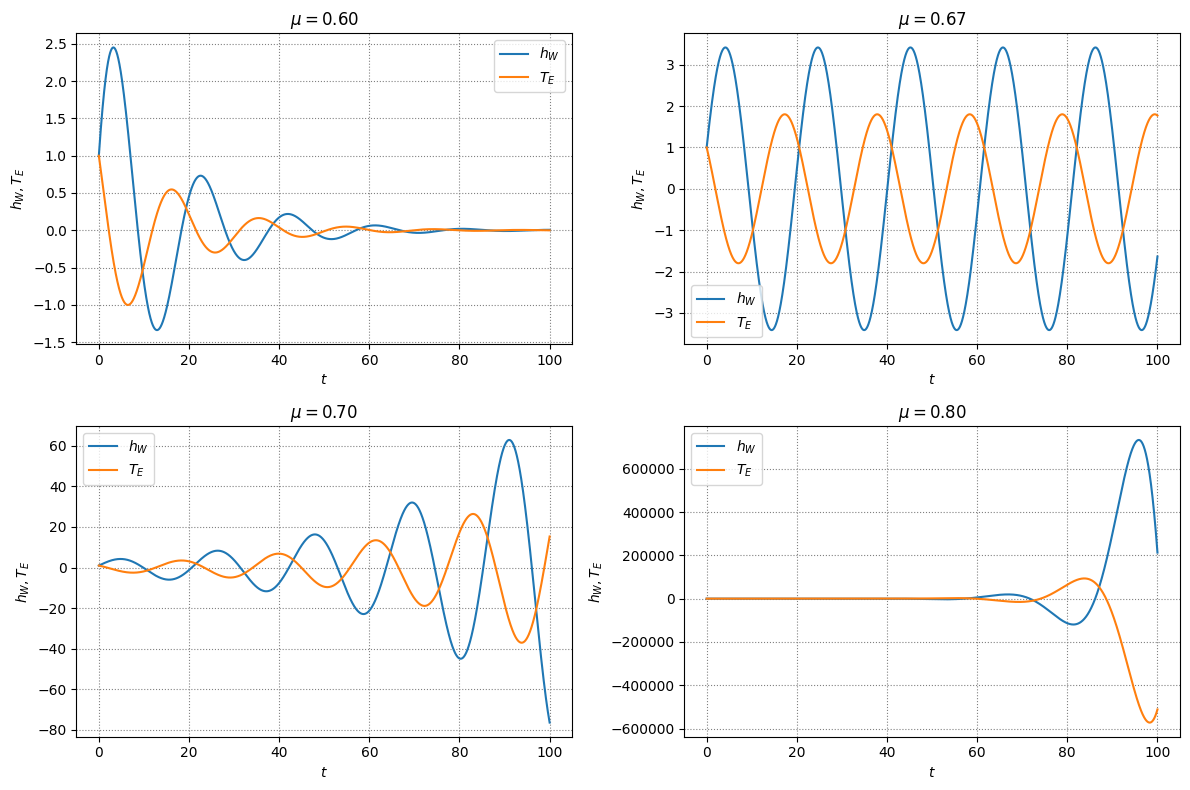

In [6]:
# Plotting for different mu values
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))
axes = [ax1, ax2, ax3, ax4]
mu_values = [0.6, 2/3, 0.7, 0.8]

for mu, ax in zip(mu_values, axes):
    params = (r, alpha, b0, c, gamma, mu, eps)
    t, solution = solve_dynamics(t0, t1, dt, initial_state, params)

    omega = solution.T
    
    # Plot h_W and T_E
    ax.plot(t, omega[1], label=r'$h_W$', color='C0')
    ax.plot(t, omega[0], label=r'$T_E$', color='C1')
    ax.set_title(f"$\mu = {mu:.2f}$")
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$h_W, T_E$')
    ax.grid(ls='dotted', color='grey')
    ax.legend()

plt.tight_layout()
plt.show()
f.savefig("docs/enso_trajectories.png", dpi=300, bbox_inches="tight");


We can also generate the vector field to visualize stationary points...

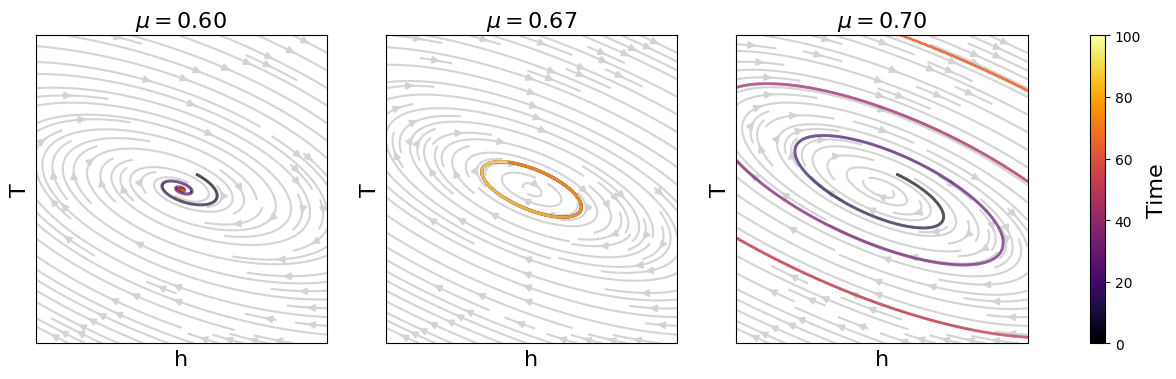

In [7]:
# Solve the system (oscillatory regime)
mus = [0.6, 2 / 3, 0.7]
f, ax = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(16, 4))

for mu_id, mu in enumerate(mus):
    params = (r, alpha, b0, c, gamma, mu, eps)
    t, solution = solve_dynamics(t0, t1, dt, initial_state, params)
    omega = solution.T.numpy()

    # Generate vector field for phase portrait
    hvec = np.linspace(-10.0, 10.0, 50)
    Tvec = np.linspace(-10.0, 10.0, 50)
    H, T = np.meshgrid(hvec, Tvec)
    
    # Compute vector field for the grid point
    F = np.array([[enso(0, torch.tensor([T_, h_]), params).numpy() for h_ in hvec] for T_ in Tvec])
    dT_field, dh_field = F[:, :, 0], F[:, :, 1]
    
    # Normalize the vector field for uniform arrow sizes in the streamplot
    magnitude = np.sqrt(dh_field**2 + dT_field**2)
    dh_field /= magnitude
    dT_field /= magnitude
    
    # Streamplot with normalized field for uniformity
    ax[mu_id].streamplot(hvec, Tvec, dh_field, dT_field, color='lightgrey', density=1.2)
    
    # Create segments for the gradient trajectory
    points = np.array([omega[1], omega[0]]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    lc = LineCollection(segments, cmap='inferno', norm=plt.Normalize(vmin=t[0], vmax=t[-1]))
    lc.set_array(t)  # Color based on time
    lc.set_linewidth(2)
    ax[mu_id].add_collection(lc)
    
    # Labels and limits
    ax[mu_id].set_xlabel(r'h', fontsize=16)
    ax[mu_id].set_ylabel(r'T', fontsize=16)
    ax[mu_id].set_xlim(hvec[0], hvec[-1])
    ax[mu_id].set_ylim(Tvec[0], Tvec[-1])
    ax[mu_id].set_title(rf'$\mu = {mu:.2f}$', fontsize=16)

    ax[mu_id].set_xticks([])
    ax[mu_id].set_yticks([])

# Add colorbar for time
sm = cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=t[0], vmax=t[-1]))
sm.set_array([])
cbar = f.colorbar(sm, ax=ax, orientation='vertical')
cbar.set_label('Time', fontsize=16)
plt.show()
f.savefig("docs/enso_phase.png", dpi=300, bbox_inches="tight");


# 2. Causal Koopman

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:29<00:00,  1.35it/s]


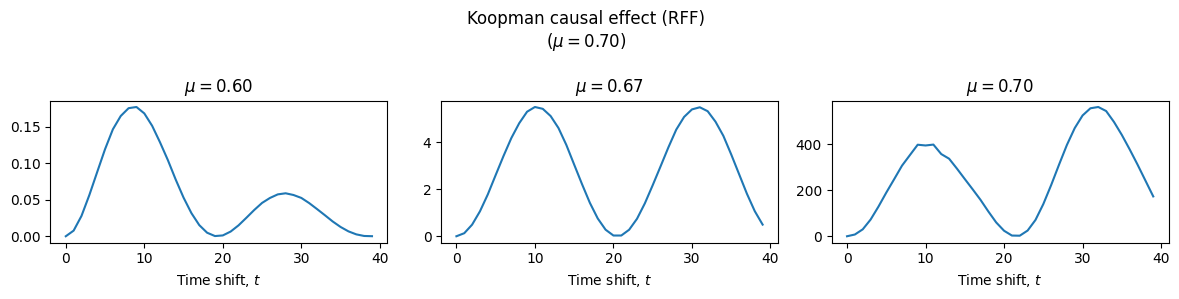

In [8]:
time_shifts = torch.arange(1, 2000, 50)
mus = [0.6, 2/3, 0.7]
initial_state = torch.tensor([1.0, 1.0])

f, ax = plt.subplots(1, len(mus), figsize=(12,3))

# Causal time shift analysis
for mu_i, mu in enumerate(mus):
    
    # Solve dynamics
    params = (r, alpha, b0, c, gamma, mu, eps)
    t, solution = solve_dynamics(t0, t1, dt, initial_state, params)
    omega = solution.T # [T, h]

    # Causal inference (T --> h)
    causal_koopman = Kausal(
        cause = omega[0:1],
        effect = omega[1:2],
    )

    causal_effect = causal_koopman.evaluate_multistep(time_shifts = time_shifts)

    f.suptitle(f"Koopman causal effect (RFF)\n($\mu = {mu:.2f}$)")
    ax[mu_i].plot(causal_effect)
    ax[mu_i].set_title(f"$\mu = {mu:.2f}$")
    ax[mu_i].set_xlabel(r'Time shift, $t$')

plt.tight_layout()
plt.show();


# 3. Deep Causal Koopman

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 69.50it/s]


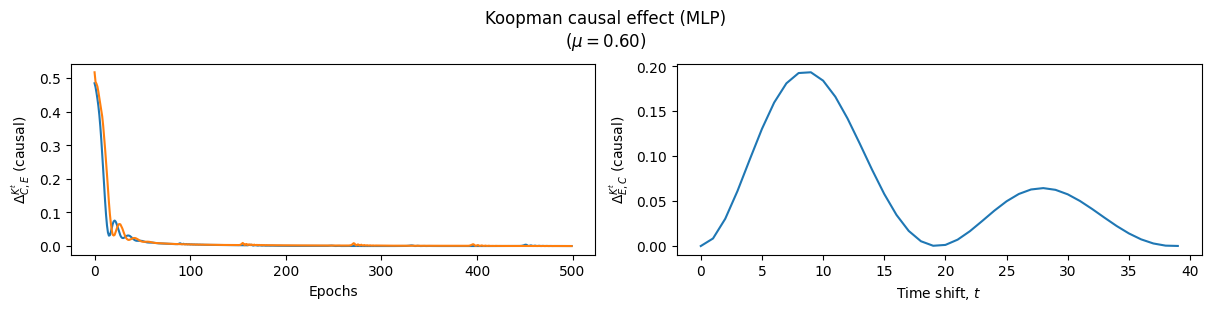

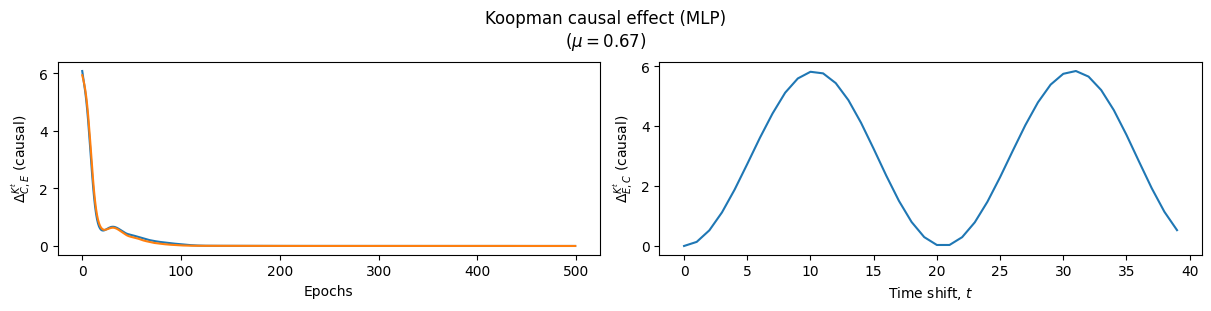

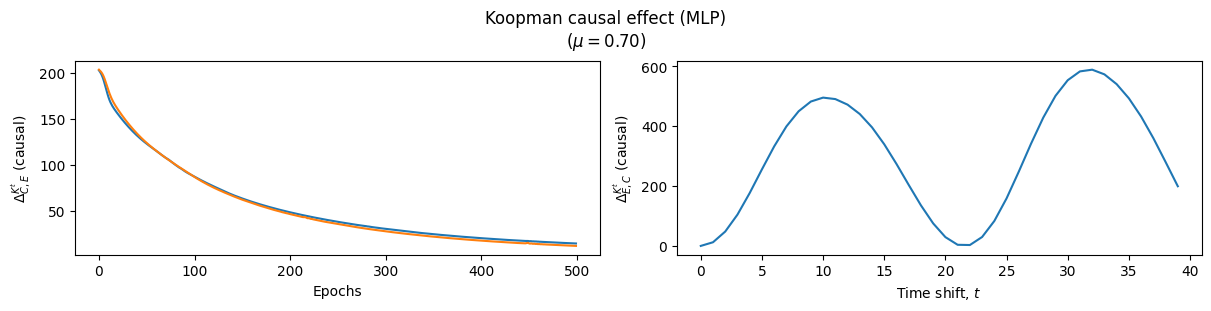

In [9]:
# Causal shifts
time_shifts = torch.arange(1, 2000, 50)
mus = [0.6, 2/3, 0.7]
initial_state = torch.tensor([1.0, 1.0])

# Hyperparameters
hidden_channels = [16, 32]
lr = 1e-2
epochs = 500

# Causal time shift analysis for each mu
for mu_i, mu in enumerate(mus):

    f, ax = plt.subplots(1, 2, figsize=(12,3), constrained_layout=True)
    
    # Solve dynamics
    params = (r, alpha, b0, c, gamma, mu, eps)
    t, solution = solve_dynamics(t0, t1, dt, initial_state, params)
    omega = solution.T # [T, h]

    # Causal inference (T --> h)
    causal_koopman = Kausal(
        marginal_observable = MLPFeatures(in_channels=1, hidden_channels=hidden_channels, out_channels=1),
        joint_observable = MLPFeatures(in_channels=2, hidden_channels=hidden_channels, out_channels=1),
        cause = omega[0:1],
        effect = omega[1:2],
    )

    # Fit observable functions
    marginal_loss_ce, joint_loss_ce = causal_koopman.fit(
        n_train = n_train, 
        epochs = epochs, 
        lr = lr, 
        batch_size = n_train
    )

    # Perform multistep causal analysis
    causal_effect = causal_koopman.evaluate_multistep(time_shifts = time_shifts)
    
    # Plot
    ax[0].plot(marginal_loss_ce, label='marginal model')
    ax[0].plot(joint_loss_ce, label='joint model')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel(r'$\Delta^{K^t}_{C,E}$ (causal)')

    ax[1].plot(causal_effect)
    ax[1].set_ylabel(r'$\Delta^{K^t}_{E,C}$ (causal)')
    ax[1].set_xlabel(r'Time shift, $t$')

    f.suptitle(f"Koopman causal effect (MLP)\n($\mu = {mu:.2f}$)")

plt.show();


# 4. Additional Experiments

Here we perform additional experiments including the comparison between different kernel types.

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 71.64it/s]


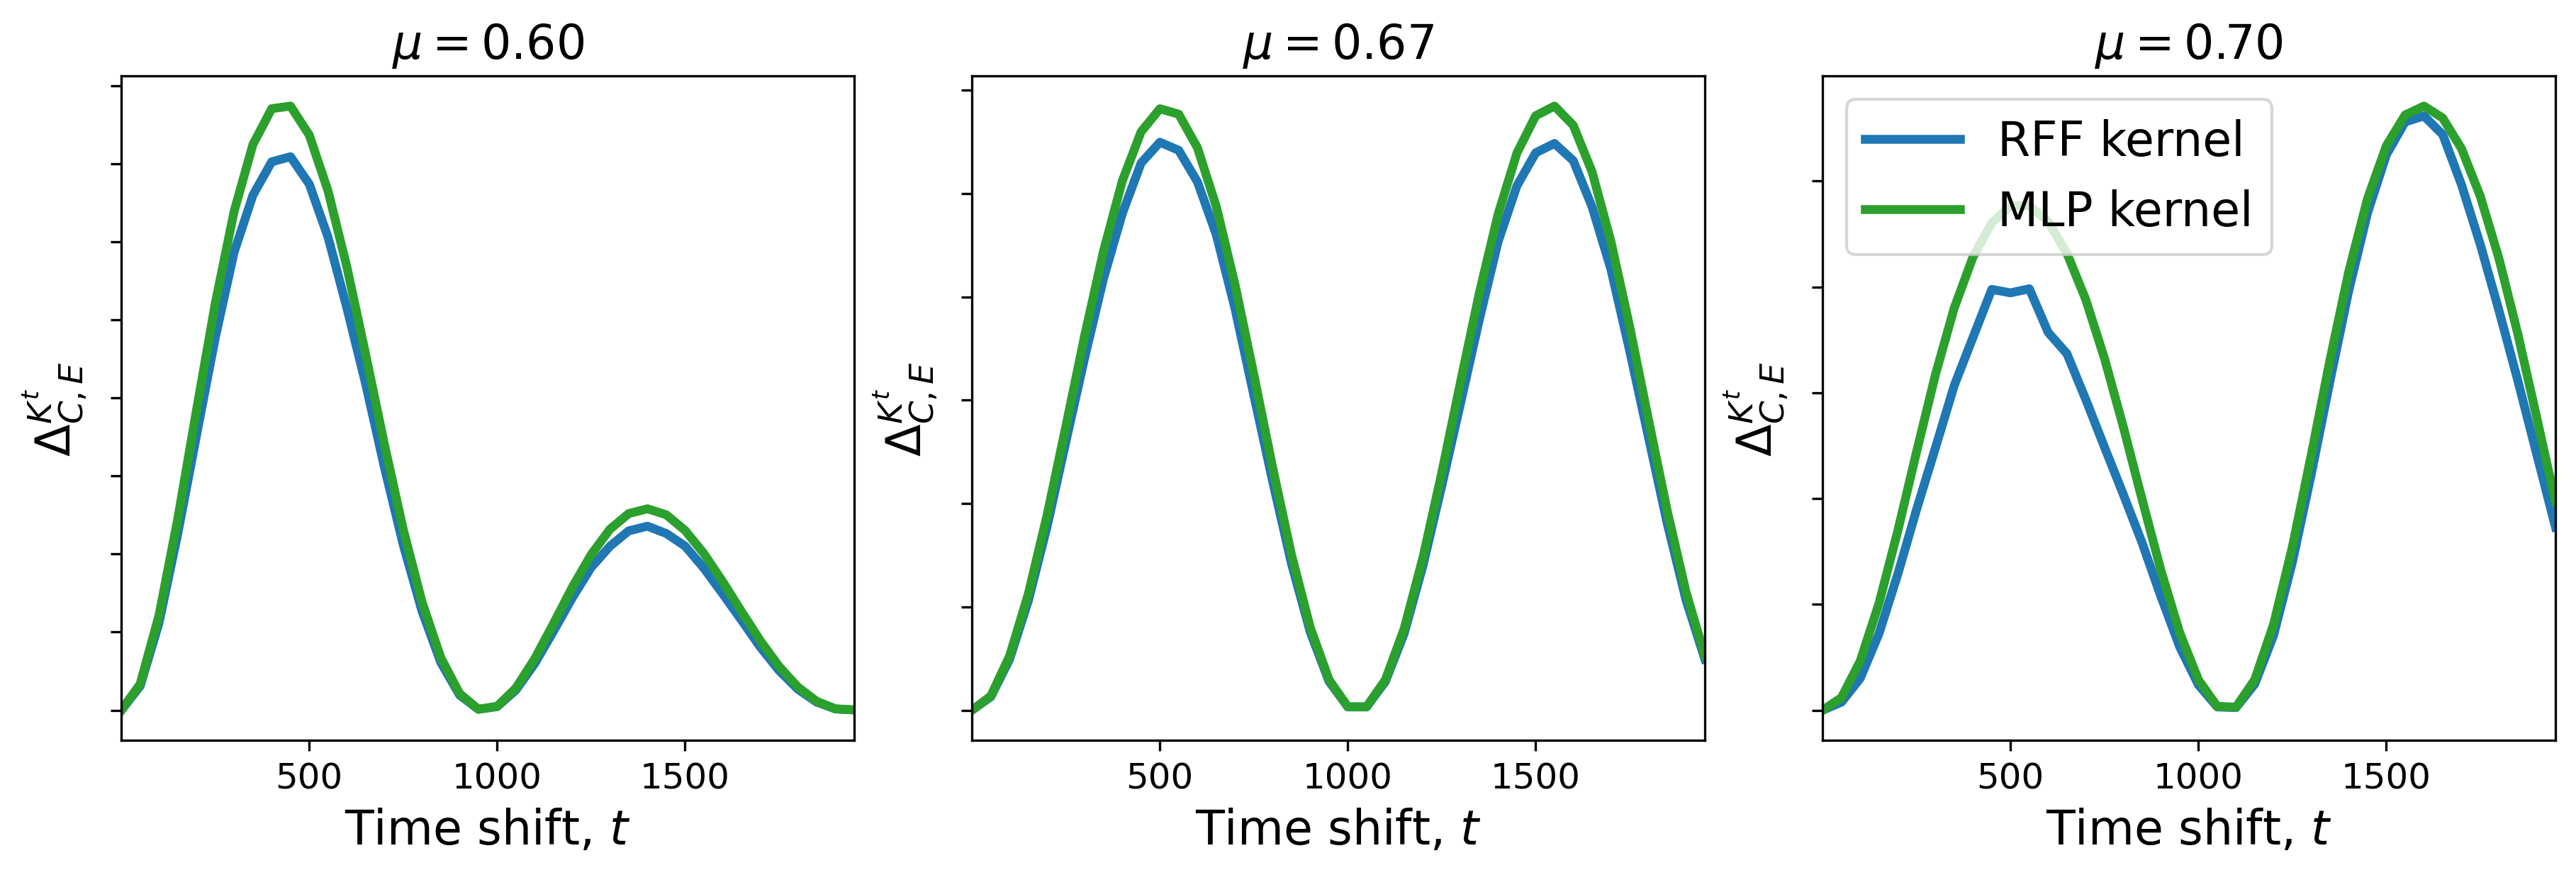

In [10]:
# Causal shift
plt.rcParams.update({
    "font.size": 14,                # General font size
    "axes.titlesize": 16,           # Title font size
    "axes.labelsize": 16,           # Axis label font size
    "xtick.labelsize": 12,          # X-axis tick label size
    "ytick.labelsize": 12,          # Y-axis tick label size
    "legend.fontsize": 16,          # Legend font size
    "lines.linewidth": 3,           # Line width
    "figure.dpi": 300,              # Higher DPI for clearer output
})

time_shifts = torch.arange(1, 2000, 50)
mus = [0.6, 2/3, 0.7]
initial_state = torch.tensor([1.0, 1.0])

f, ax = plt.subplots(1, len(mus), figsize=(12, 4), constrained_layout=True)

for mu_id, mu in enumerate(mus):

    # Solve dynamics
    params = (r, alpha, b0, c, gamma, mu, eps)
    t, solution = solve_dynamics(t0, t1, dt, initial_state, params)
    omega = solution.T
    
    ## RFF
    causal_koopman_rff = Kausal(cause = omega[0:1], effect = omega[1:2])
    causal_effect_rff = causal_koopman_rff.evaluate_multistep(time_shifts = time_shifts)
    
    ## MLP
    hidden_channels = [16, 32]
    lr = 1e-2
    epochs = 500
    
    causal_koopman_mlp = Kausal(
        marginal_observable = MLPFeatures(in_channels=1, hidden_channels=hidden_channels, out_channels=1),
        joint_observable = MLPFeatures(in_channels=2, hidden_channels=hidden_channels, out_channels=1),
        cause = omega[0:1],
        effect = omega[1:2],
    )
    
    _, _ = causal_koopman_mlp.fit(
        n_train = n_train, 
        epochs = epochs, 
        lr = lr, 
        batch_size = n_train
    )
    
    causal_effect_mlp = causal_koopman_mlp.evaluate_multistep(time_shifts = time_shifts)
    
    # Plot causal shift
    # NOTE: increasing causal error in the true causal direction as time dependency increases.
    # NOTE: also significant difference between C --> E and E --> C, indicating strong causal signal between C --> E.

    ax[mu_id].plot(time_shifts, causal_effect_rff, linestyle='-', color='C0', label='RFF kernel')
    ax[mu_id].plot(time_shifts, causal_effect_mlp, linestyle='-', color='C2', label='MLP kernel')
    
    
    ax[mu_id].set_xlabel(r'Time shift, $t$', fontsize=16)
    ax[mu_id].set_xlim([time_shifts[0], time_shifts[-1]])
    ax[mu_id].set_ylabel(r'$\Delta^{K^t}_{C,E}$', fontsize=16)
    ax[mu_id].set_yticklabels([])
    ax[mu_id].set_title(rf'$\mu = {mu:.2f}$', fontsize=16)
    
plt.legend()
plt.show()
f.savefig("docs/enso_estimation.png", dpi=300, bbox_inches="tight");
